In [2]:
!pip install apyori

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import squarify 
import os 
import warnings
warnings.filterwarnings("ignore")

from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt
import zipfile
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip


In [4]:
zip_orders_train = "order_products__train.csv"
zip_orders_prior = "order_products__prior.csv"
zip_orders = 'orders.csv'
zip_products = 'products.csv'
zip_departments = 'departments.csv'
zip_aisles = 'aisles.csv'

archive_orders_train = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_orders_train+".zip","r")
archive_orders_prior = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_orders_prior+".zip","r")
archive_orders = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_orders+".zip","r")
archive_products = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_products+".zip","r")
archive_departments = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_departments+".zip","r")
archive_aisles = zipfile.ZipFile("../input/instacart-market-basket-analysis/"+zip_aisles+".zip","r")

df_order_train = pd.read_csv(archive_orders_train.open('order_products__train.csv'))
df_order_prior = pd.read_csv(archive_orders_prior.open('order_products__prior.csv'))
df_order = pd.read_csv(archive_orders.open('orders.csv'))
df_product = pd.read_csv(archive_products.open('products.csv'))
df_departments = pd.read_csv(archive_departments.open('departments.csv'))
df_aisles = pd.read_csv(archive_aisles.open('aisles.csv'))

Let's explore the dataset.

In [5]:
df_merged = pd.merge(df_product,df_aisles,on='aisle_id')
df_merged = pd.merge(df_merged,df_departments,on='department_id')

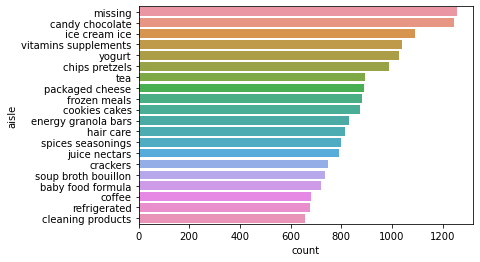

In [6]:
aisle_top = df_merged['aisle'].value_counts().nlargest(20)
aisle_top = pd.DataFrame(aisle_top.reset_index())
aisle_top.columns = ['aisle','count']
_ = sns.barplot(y = 'aisle', x='count',data=aisle_top)

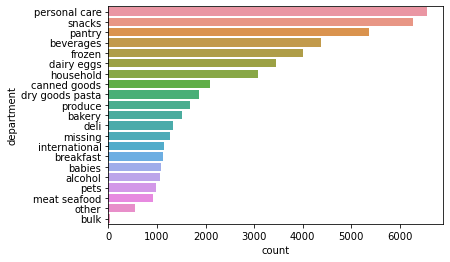

In [7]:
_ = sns.countplot(y=df_merged['department'],order = df_merged['department'].value_counts().index)

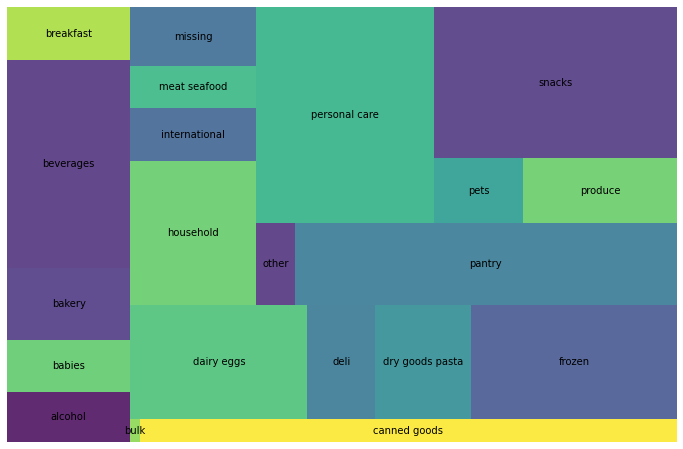

In [8]:
a = df_merged.groupby('department')[['aisle']].sum().index.get_level_values(0).tolist() 
d = df_merged.groupby('department')[['aisle']].count().reset_index().aisle.values.tolist()
plt.figure(figsize=(12,8)) 
squarify.plot(sizes=d,label=a,alpha=0.85 )
plt.axis('off')
plt.show()

In [9]:
df_order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
df_order['user_id'].nunique()

206209

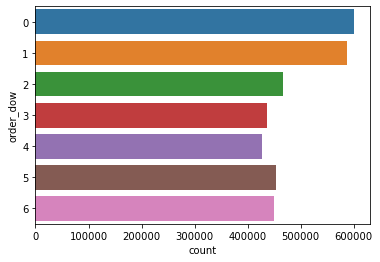

In [11]:
_ = sns.countplot(y = 'order_dow',data=df_order)

Most of the orders are places on day 0 and day 1. This could be the weekends suggesting people order more on weekends. 

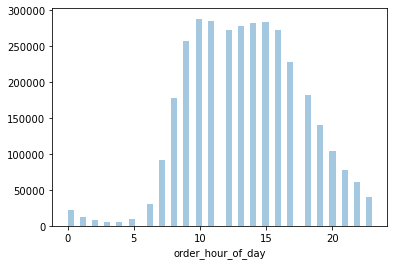

In [12]:
_ = sns.distplot(df_order['order_hour_of_day'],kde=False)

Order peaks are observed in the morning from 9 am and slows down in the afternoon.

In [13]:
df = df_order.groupby(['order_dow','order_hour_of_day'])['order_number'].count().reset_index()

In [14]:
df = pd.pivot_table(data=df,
                    index='order_dow',
                    values='order_number',
                    columns='order_hour_of_day')

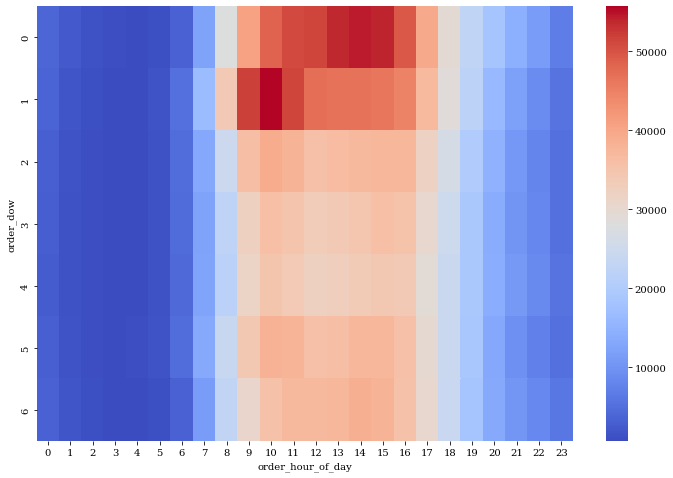

In [15]:
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.family'] = "serif"
_ = sns.heatmap(df,cmap='coolwarm')

Early Sunday morning and late Saturday evenings are peak time for ordering

In [16]:
order_by_user = pd.DataFrame(df_order.groupby('user_id')['order_number'].count())

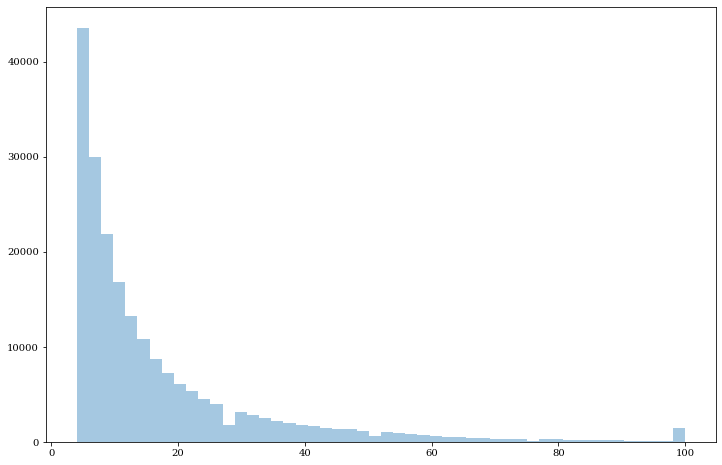

In [17]:
_ = sns.distplot(order_by_user,kde=False)

days since prior order has some missing values. Lets analyze this column

In [18]:
df_order[df_order['days_since_prior_order'].isnull()]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


For each user the nan value corresponds to their first order. For all users the first order has no record of prior days to order and so the column is set to null. We can replace this with 0 

In [19]:
df_order['days_since_prior_order'] = df_order['days_since_prior_order'].fillna(0) 

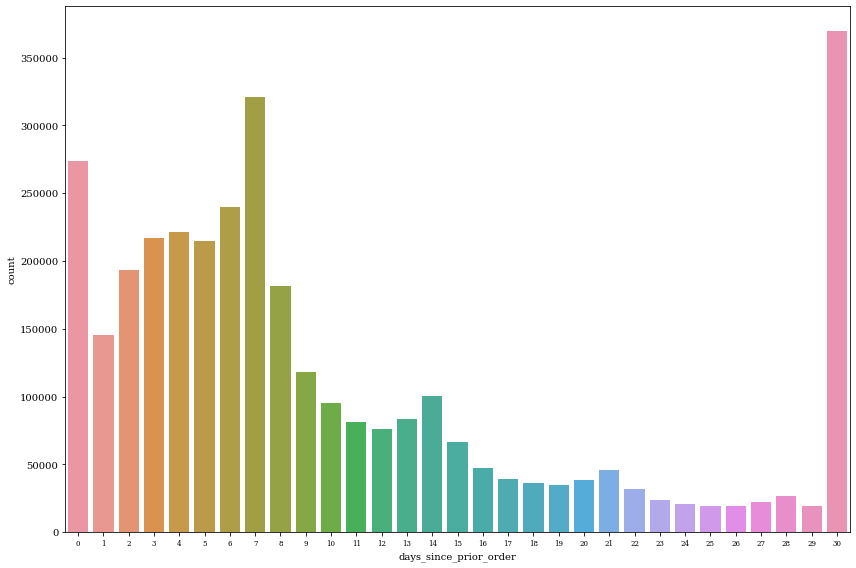

In [20]:
from  matplotlib.ticker import FuncFormatter

ax = sns.countplot(x=df_order['days_since_prior_order'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.show()

The reordering has a trend to it which can be broken down into 4 groups: 
* Reorder daily: a large number of people seem to reorder on a daily basis. 
* Reorder weekly: the next visible trend is a weekly order. This could be mostly the produce and dairy items. 
* Reorder biweekly: some group of products are ordered every 15 days. 
* Reorder monthly: After that majority of reoder happends on day 30. 

We will classify reordering pattern into these 4 sub categories and explore the items purchased during each times. 

In [21]:
# Set a default value
df_order['reorder_pattern'] = 'daily'
df_order['reorder_pattern'][df_order['days_since_prior_order'] <= 1] = 'daily'
df_order['reorder_pattern'][(df_order['days_since_prior_order'] > 1) & (df_order['days_since_prior_order'] <= 7)]  = 'weekly'
df_order['reorder_pattern'][(df_order['days_since_prior_order'] > 7) & (df_order['days_since_prior_order'] <= 15)]  = 'biweekly'
df_order['reorder_pattern'][(df_order['days_since_prior_order'] > 15) & (df_order['days_since_prior_order'] <= 30)]  = 'monthly'

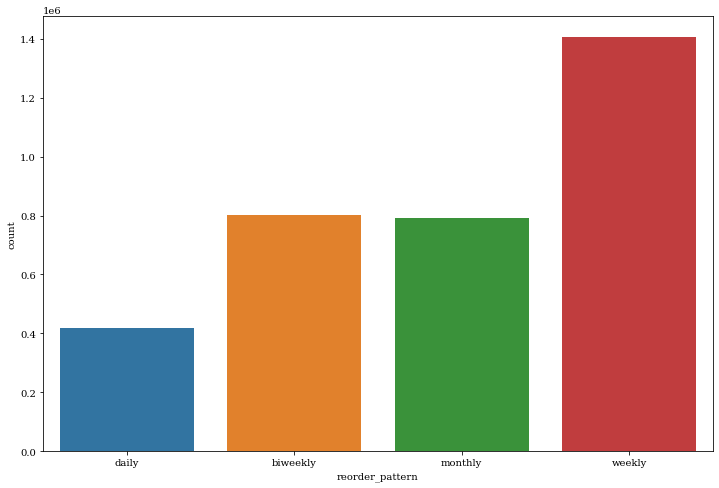

In [22]:
_ = sns.countplot(x=df_order['reorder_pattern'])

Most of the orders are on w weekly basis.

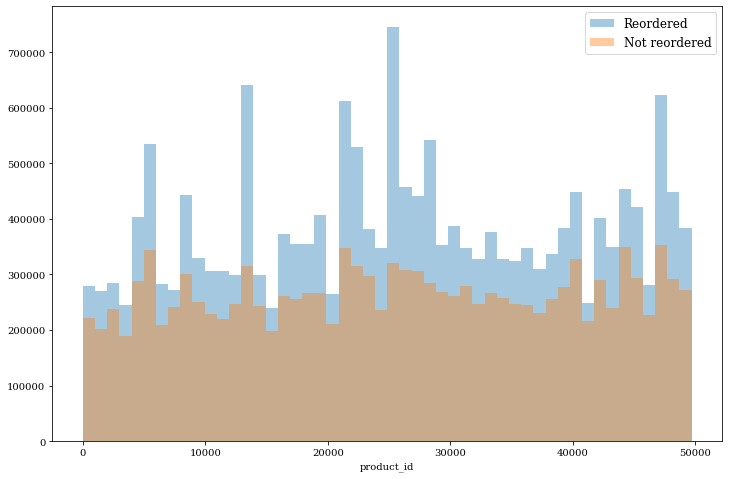

In [23]:
_ = sns.distplot(df_order_prior[df_order_prior['reordered']==1]['product_id'],  kde=False, label='Reordered')
_ = sns.distplot(df_order_prior[df_order_prior['reordered']==0]['product_id'],  kde=False, label='Not reordered')


# Plot formatting
plt.legend(prop={'size': 12})
plt.show()

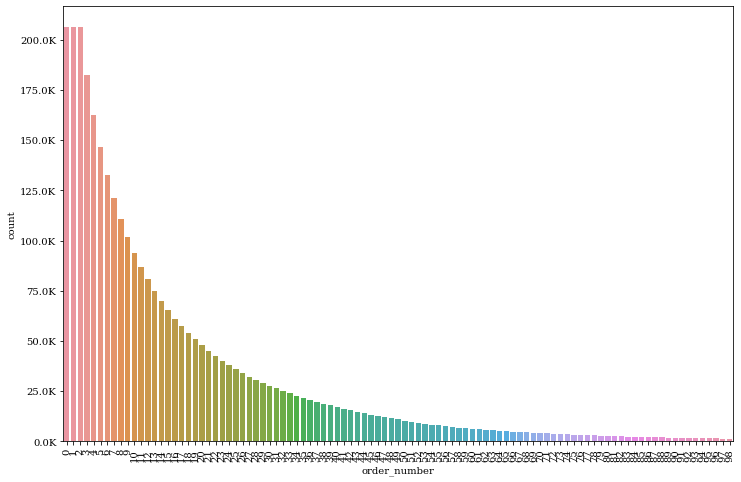

In [24]:
from  matplotlib.ticker import FuncFormatter

ax = sns.countplot(x = df_order[df_order['eval_set']=='prior']['order_number'])
labels = []
for x in ax.get_yticks():
    val = round(x/1000,0)
    M = '{:}K'.format(val)
    labels.append(M)
ax = plt.gca()
ax.set_yticklabels(labels)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.show()

In [25]:
df_order_prior['reordered'].value_counts()/len(df_order_prior['reordered'])

1    0.589697
0    0.410303
Name: reordered, dtype: float64

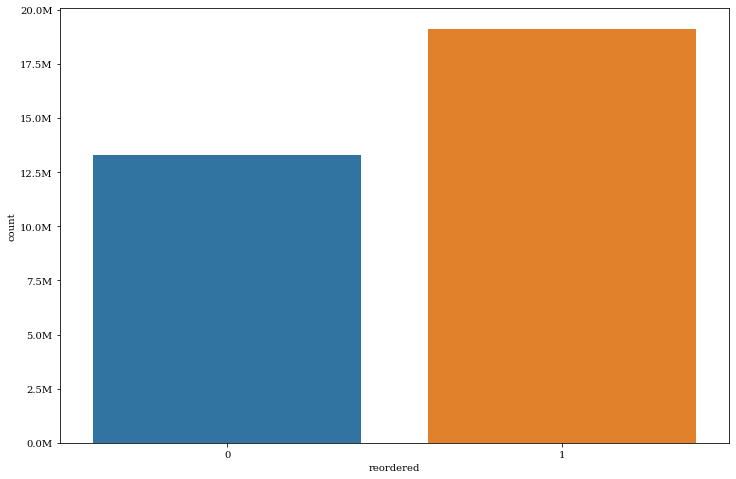

In [26]:
ax = sns.countplot(x = df_order_prior['reordered'])
labels = []
for x in ax.get_yticks():
    val = round(x/1000000,1)
    M = '{:}M'.format(val)
    labels.append(M)
ax = plt.gca()
ax.set_yticklabels(labels)
plt.show()

In [27]:
prior = df_order_prior.merge(df_order,on='order_id')

In [28]:
prior = prior.drop(columns=['user_id','order_dow','order_hour_of_day','days_since_prior_order'])

In [29]:
prior = prior.merge(df_product,on='product_id')

In [30]:
prior = prior.drop(columns=['department_id','aisle_id','order_number'])

In [31]:
top_product = prior.product_name.value_counts().nlargest(10)

In [32]:
top_product = top_product.reset_index()

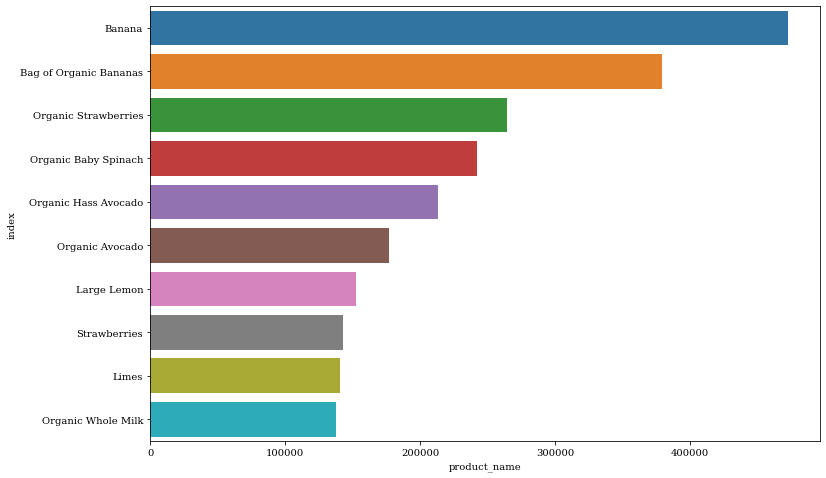

In [33]:
_ = sns.barplot(y=top_product['index'],x=top_product['product_name'])

In [34]:
prior = prior[prior['reordered']==1]

In [35]:
top_reordered = prior.product_name.value_counts().nlargest(10)
top_reordered = top_reordered.reset_index()

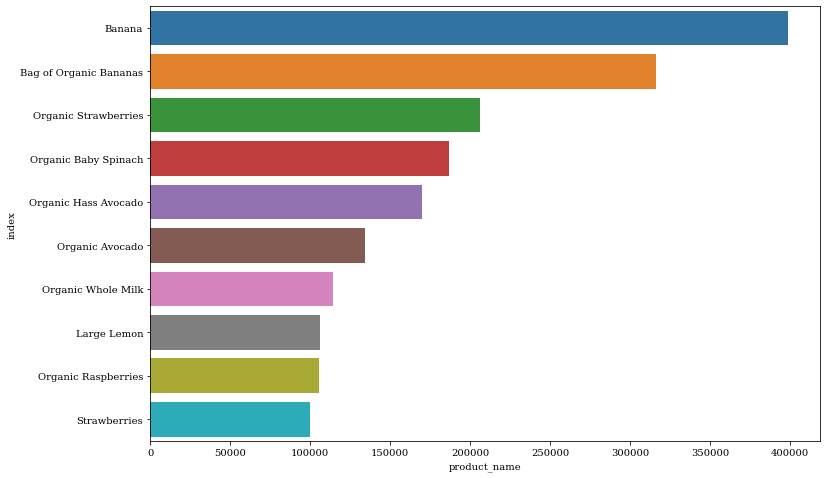

In [36]:
_ = sns.barplot(y=top_reordered['index'],x=top_reordered['product_name'])

In [37]:
df = prior.groupby(['order_id','product_name'])['add_to_cart_order'].sum()

In [38]:
df_new = df.nlargest(100000)

In [39]:
df_new = df_new.unstack().reset_index().fillna(0).set_index('order_id')

In [40]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1       

In [41]:
df_basket = df_new.applymap(encode_units)

In [43]:
df_filter_plus = df_basket[(df_basket > 0).sum(axis=1) >= 2]

In [44]:
from mlxtend.frequent_patterns import apriori

In [45]:
frequent_items_plus = apriori(df_filter_plus,min_support=0.005,use_colnames=True).sort_values('support',ascending=False).reset_index(drop=True)

In [46]:
frequent_items_plus['length'] = frequent_items_plus['itemsets'].apply(lambda x: len(x))

In [47]:
frequent_items_plus.length.value_counts()

1    127
Name: length, dtype: int64

In [48]:
from mlxtend.frequent_patterns import association_rules

In [49]:
association_rules(frequent_items_plus,metric='lift',min_threshold=0.005).sort_values('lift',ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
